# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Цель:
Построить модель для определения стоимости автомобиля, с учетом важных для заказчика параметорв:**

- качество предсказания;
- скорость предсказания;
- время обучения.


Основные шаги:
1. Загрузить данные (путь к файлу: /datasets/autos.csv).
2. Изучить данные. Заполнить пропущенные значения и обработайть аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
3. Подготовить выборки для обучения моделей.
4. Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
5. Проанализировать время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

Описание данных
Данные находятся в файле /datasets/autos.csv.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [1]:
!pip install missingno

In [2]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

#комментарий студента v1
from sklearn.preprocessing import OneHotEncoder
from time import time

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

#комментарий студента v1
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [3]:
try:
    try:
    #локальная версия
        df = pd.read_csv('\datasets\autos.csv')
    except:    
    #сетевая версия
        df = pd.read_csv('/datasets/autos.csv')
except:
    print('Не удалось прочесть файл. Возможно, был указан не верный путь.')

In [4]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [7]:
df.rename(columns={'DateCrawled': 'date_crawled',
                   'Price': 'price',
                   'VehicleType': 'vehicle_type',
                   'RegistrationYear': 'registration_year',
                   'Gearbox': 'gearbox',
                   'Power': 'power',
                   'Model': 'model',
                   'Kilometer': 'kilometer',
                   'RegistrationMonth': 'registration_month',
                   'FuelType': 'fuel_type',
                   'Brand': 'brand',
                   'Repaired': 'repaired',
                   'DateCreated': 'date_created',
                   'NumberOfPictures': 'number_of_pictures',
                   'PostalCode': 'postal_code',
                   'LastSeen': 'last_seen'
                  },
                    inplace=True
         )

In [8]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [10]:
total_count_1 = len(df)

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
#msno.matrix(df, labels=True)

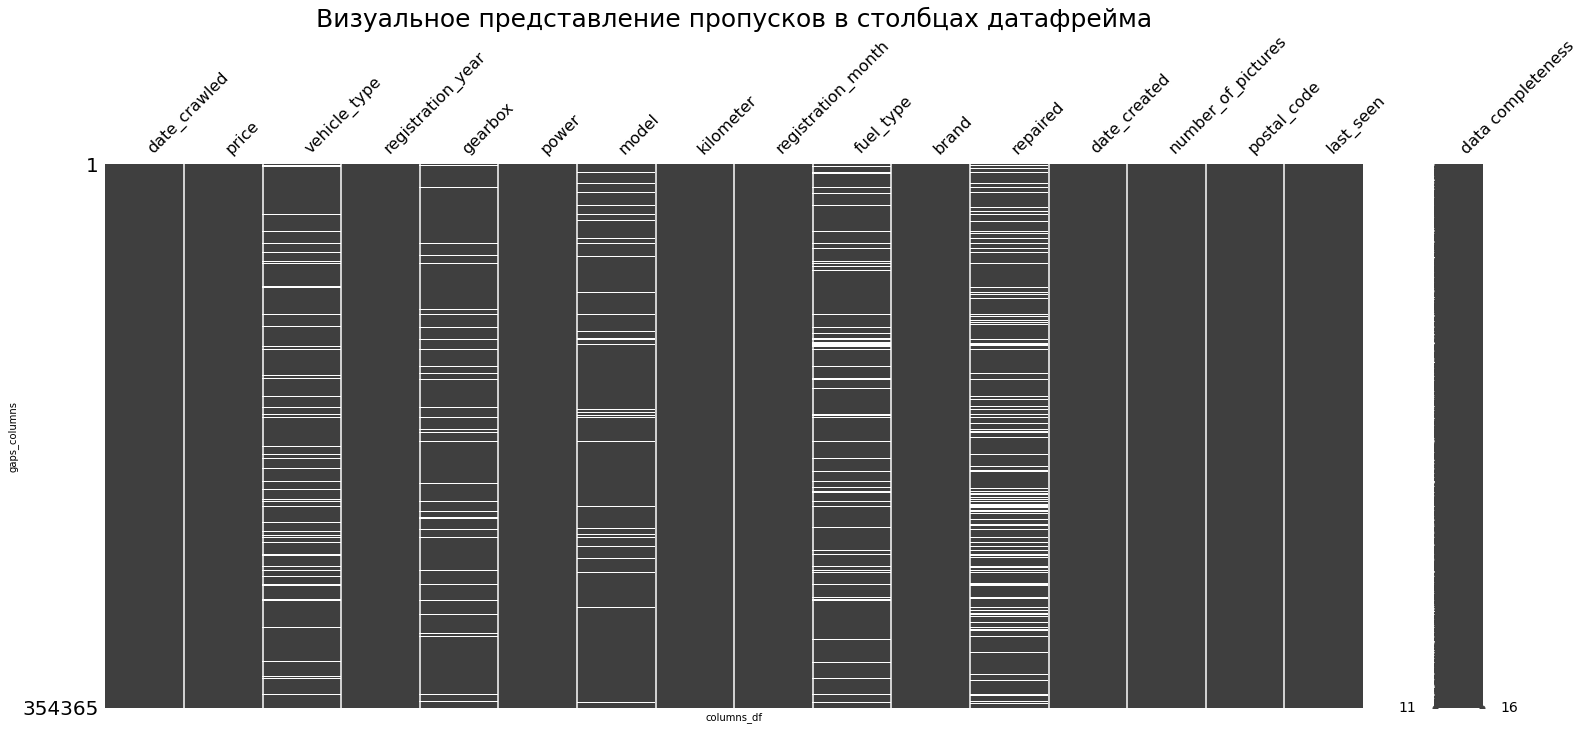

In [14]:
msno.matrix(df, labels=True)

# Установка размера графиков
plt.rcParams["figure.figsize"] = (15, 12)

# Добавление названия графику
plt.title("Визуальное представление пропусков в столбцах датафрейма", size=25)

# Подпись осей X и Y
plt.xlabel("columns_df")
plt.ylabel("gaps_columns")

# Удаление технических комментариев и отображение графика
plt.show()

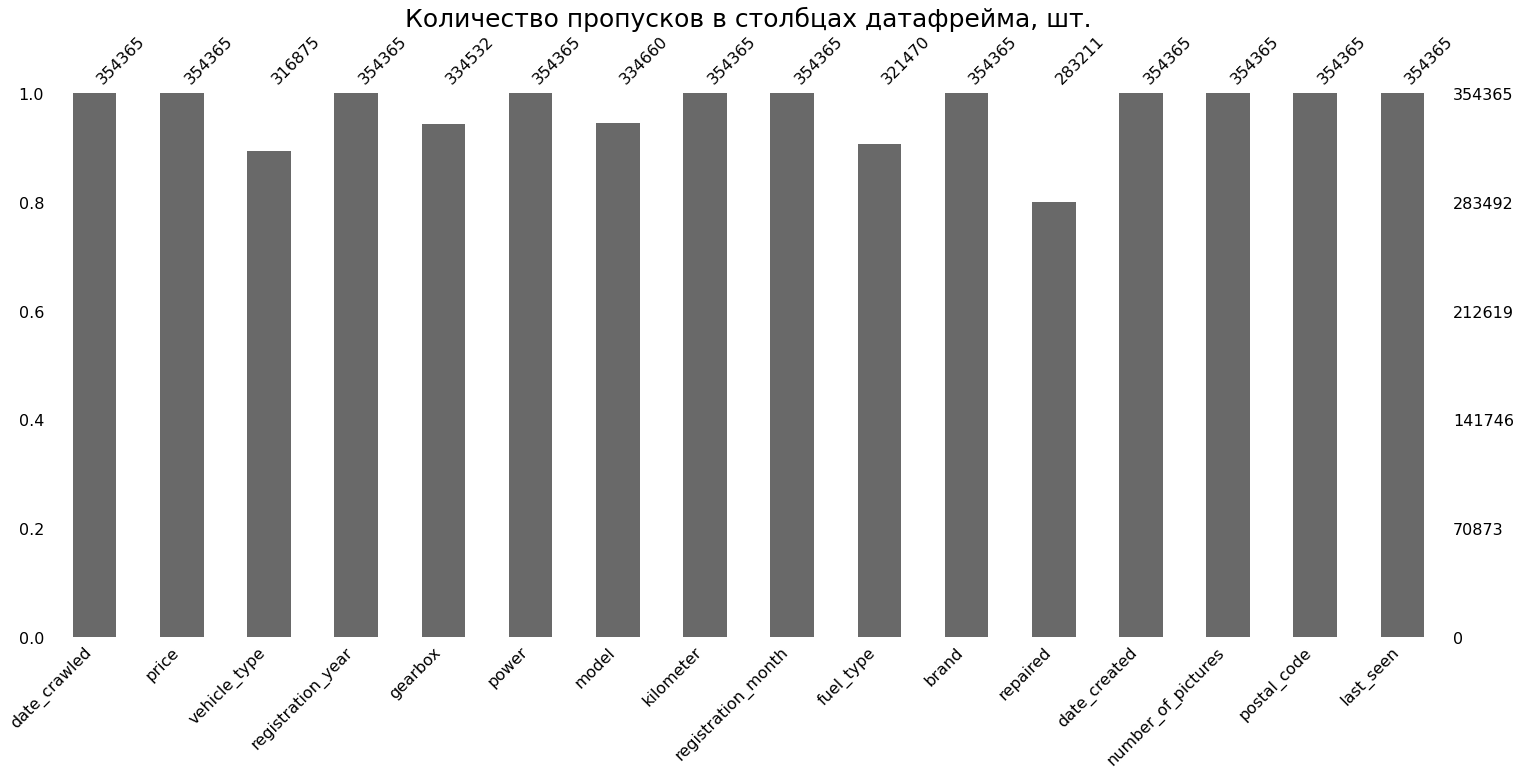

In [16]:
msno.bar(df)

# Добавление названия графику
plt.title("Количество пропусков в столбцах датафрейма, шт.", size=25)

# Удаление технических комментариев и отображение графика
plt.show()

In [17]:
df.nunique()

date_crawled          271174
price                   3731
vehicle_type               8
registration_year        151
gearbox                    2
power                    712
model                    250
kilometer                 13
registration_month        13
fuel_type                  7
brand                     40
repaired                   2
date_created             109
number_of_pictures         1
postal_code             8143
last_seen             179150
dtype: int64

In [18]:
missing_values = df.isna().mean() * 100
round(missing_values, 2)

date_crawled           0.00
price                  0.00
vehicle_type          10.58
registration_year      0.00
gearbox                5.60
power                  0.00
model                  5.56
kilometer              0.00
registration_month     0.00
fuel_type              9.28
brand                  0.00
repaired              20.08
date_created           0.00
number_of_pictures     0.00
postal_code            0.00
last_seen              0.00
dtype: float64

В некоторых столбцах много пропусков промаркируем их.

In [19]:
def marking(df, columns_list):
    [df[i].fillna('unknown', inplace=True) for i in columns_list]
    return df
mark_list = ['vehicle_type', 'fuel_type', 'gearbox', 'model', 'repaired']

In [21]:
marking(df, mark_list)
# not_repaired_clean(df)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,unknown,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,unknown,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


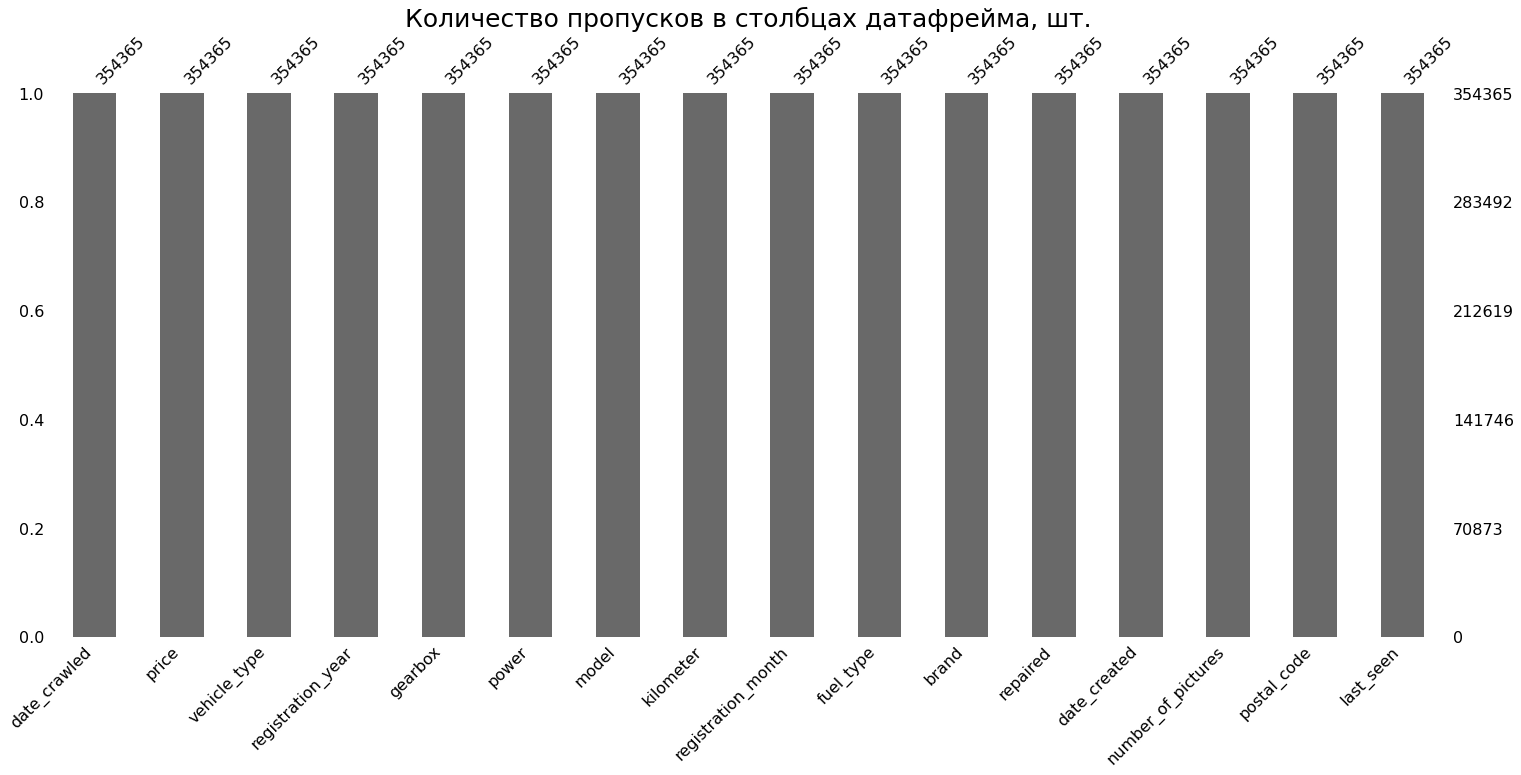

In [22]:
msno.bar(df)

# Добавление названия графику
plt.title("Визуальное представление пропусков в столбцах датафрейма", size=25)

# Добавление названия графику
plt.title("Количество пропусков в столбцах датафрейма, шт.", size=25)

# Удаление технических комментариев и отображение графика
plt.show()

Удалим ненужные для обучения столбцы

In [23]:
date_crawled_max = df['date_crawled'].max()

In [24]:
df = df.drop(columns=['last_seen',
                      'date_crawled',
                      'registration_month',
                      'date_created',
                      'number_of_pictures',
                      'postal_code'
                     ]
            )
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,unknown,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,unknown,2005,unknown,0,unknown,20000,unknown,sonstige_autos,unknown
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [25]:
df.duplicated().sum()

45036

In [26]:
df.drop_duplicates(inplace=True)

In [27]:
#Удалим строки, где price <1
df = df[df['price']>1]
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354365,2200,unknown,2005,unknown,0,unknown,20000,unknown,sonstige_autos,unknown
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [28]:
df = df[(df['price']>2000)]

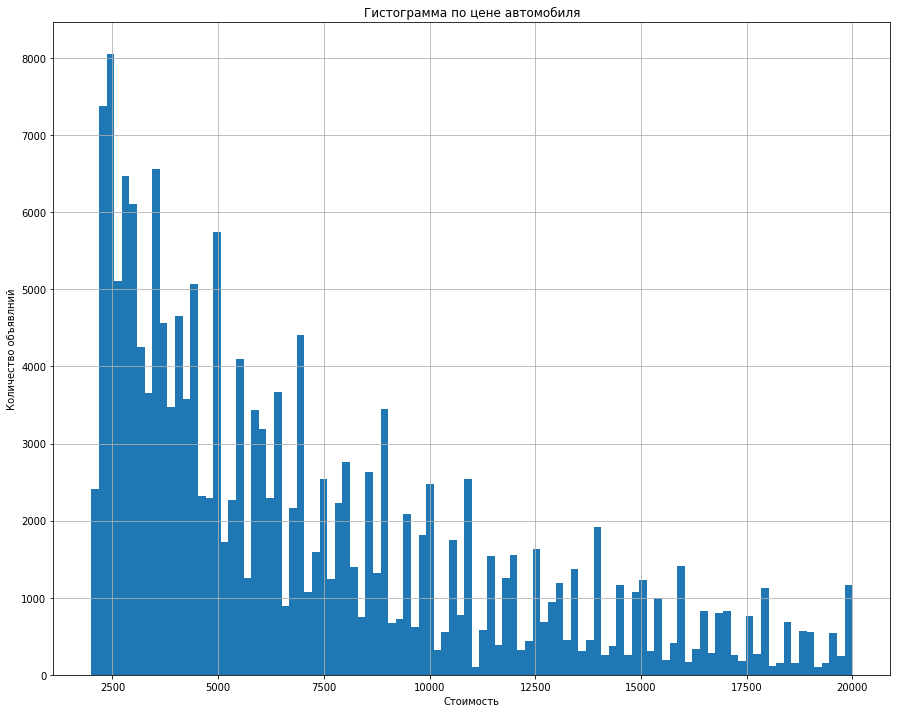

In [30]:
df['price'].hist(bins=100)

# Добавление названия графику
plt.title("Гистограмма по цене автомобиля")

# Подпись осей X и Y
plt.xlabel("Стоимость")
plt.ylabel("Количество объявлний")

# Удаление технических комментариев и отображение графика
plt.show()

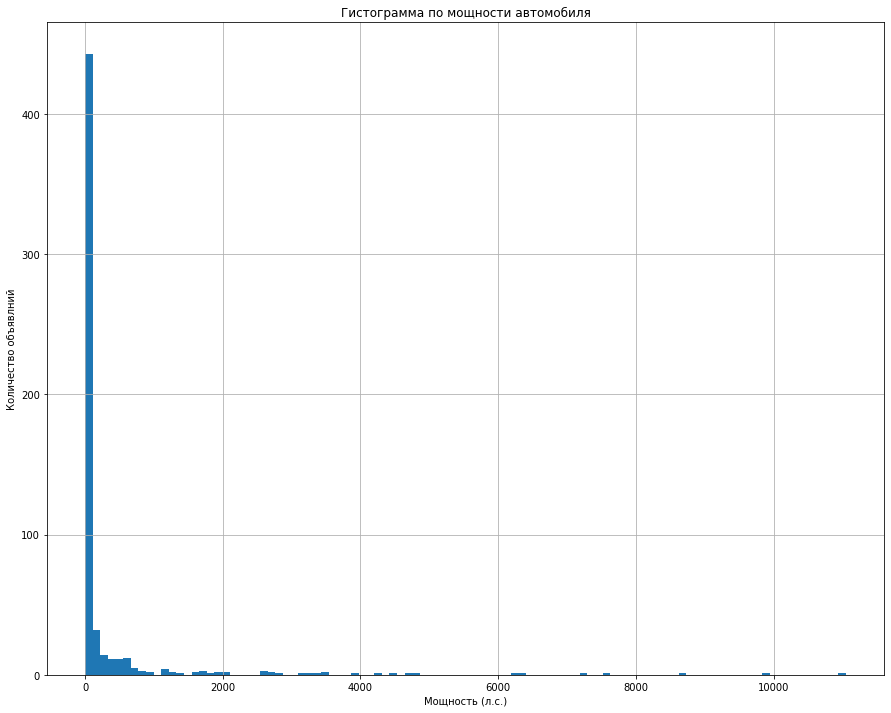

In [32]:
df['power'].value_counts().sort_index().hist(bins=100)

# Добавление названия графику
plt.title("Гистограмма по мощности автомобиля")

# Подпись осей X и Y
plt.xlabel("Мощность (л.с.)")
plt.ylabel("Количество объявлний")

# Удаление технических комментариев и отображение графика
plt.show()

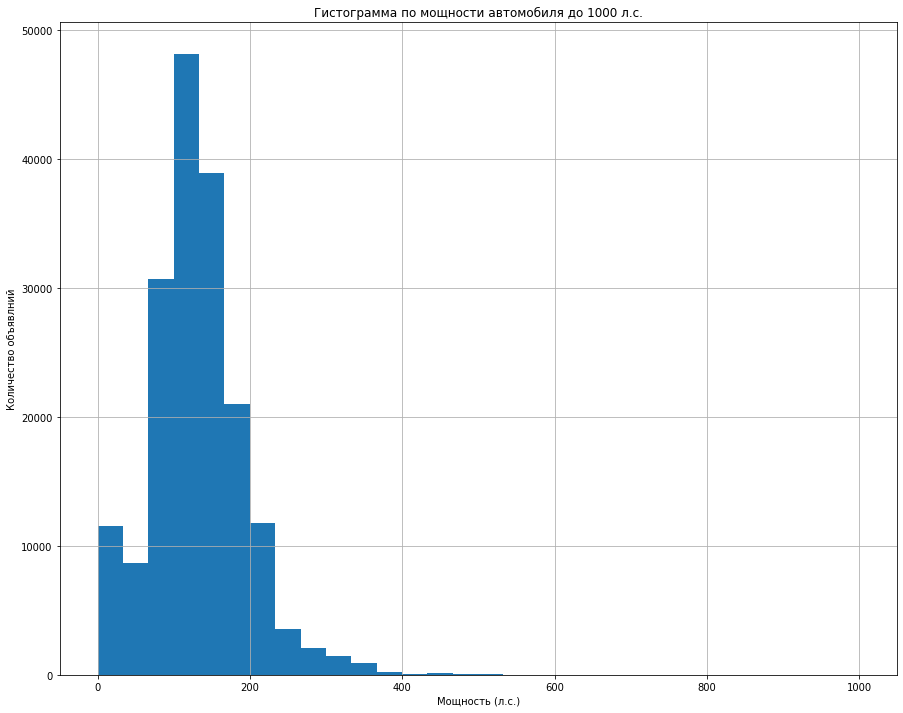

In [34]:
df[df['power']<1000]['power'].hist(bins = 30)

# Добавление названия графику
plt.title("Гистограмма по мощности автомобиля до 1000 л.с.")

# Подпись осей X и Y
plt.xlabel("Мощность (л.с.)")
plt.ylabel("Количество объявлний")

# Удаление технических комментариев и отображение графика
plt.show()

Посмотрим на количество строк с мощностью меньше 10 и больше 450.

In [35]:
len(df[(df['power']>450) | (df['power']<10)]['power'])

11452

In [36]:
# #посмотрим на выбросы
# df = df[(df['power']<450) & (df['power']>10)]
# plt.boxplot(df['power'])
# plt.show()

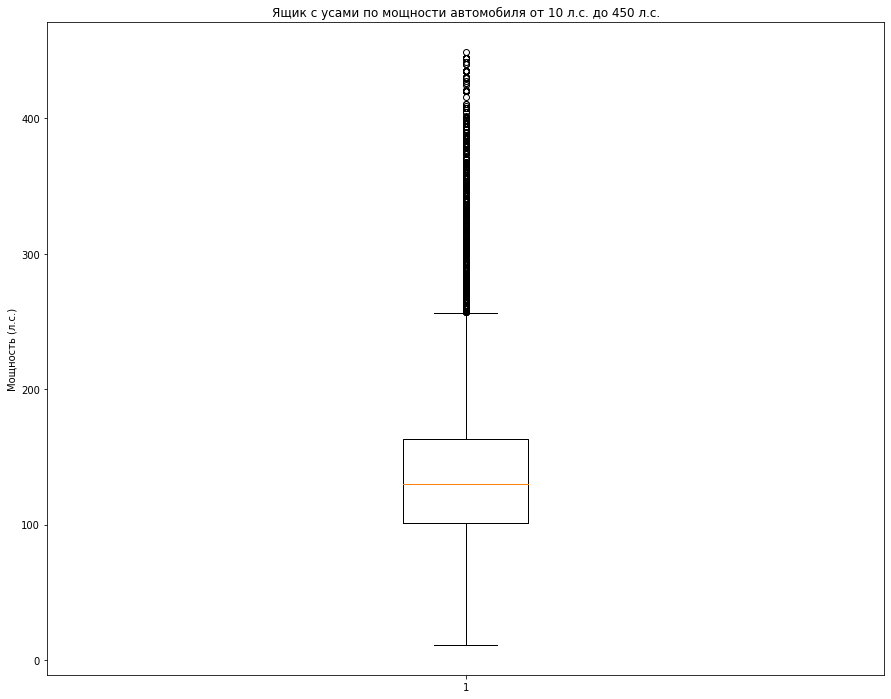

In [37]:
#посмотрим на выбросы
df = df[(df['power']<450) & (df['power']>10)]
# Добавление названия графику
plt.title("Ящик с усами по мощности автомобиля от 10 л.с. до 450 л.с.")
plt.boxplot(df['power'])
# Подпись осей X и Y
plt.ylabel("Мощность (л.с.)")

# Удаление технических комментариев и отображение графика
plt.show()

In [38]:
df['registration_year'].sort_values().unique()

array([1000, 1500, 1800, 1910, 1923, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2900, 4500, 5000, 5911,
       6000])

In [40]:
date_crawled_max

'2016-04-07 14:36:58'

In [41]:
df = df[(df['registration_year'] >= 1990) & (df['registration_year'] < 2016)]

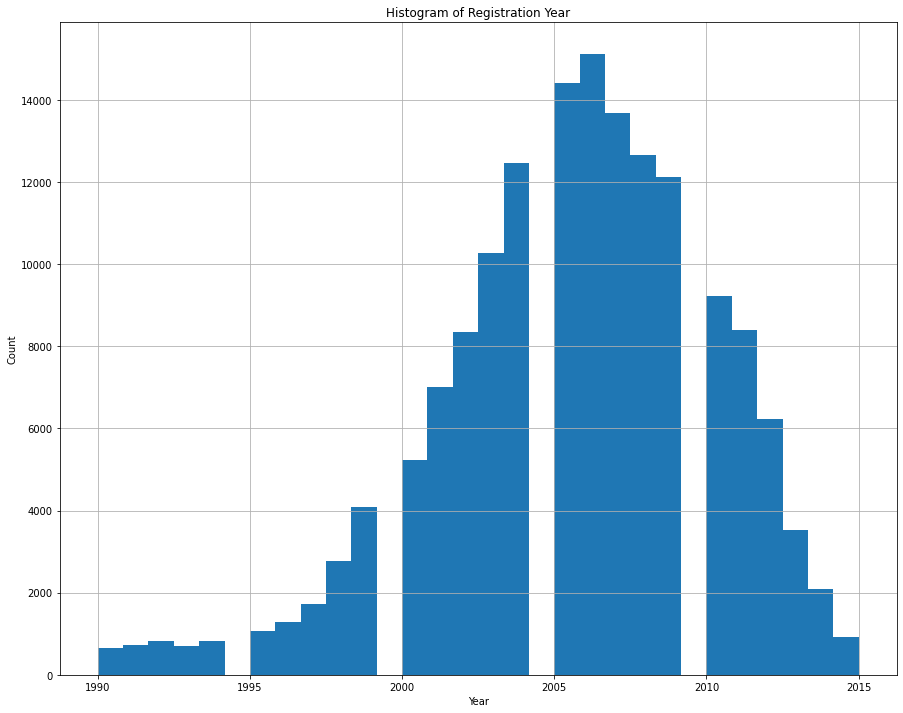

In [42]:
# Выводим гистограмму по годам
df['registration_year'].sort_values().hist(bins=30)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Histogram of Registration Year')
plt.show()

In [43]:
df.reset_index(inplace=True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156321 entries, 0 to 156320
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   index              156321 non-null  int64 
 1   price              156321 non-null  int64 
 2   vehicle_type       156321 non-null  object
 3   registration_year  156321 non-null  int64 
 4   gearbox            156321 non-null  object
 5   power              156321 non-null  int64 
 6   model              156321 non-null  object
 7   kilometer          156321 non-null  int64 
 8   fuel_type          156321 non-null  object
 9   brand              156321 non-null  object
 10  repaired           156321 non-null  object
dtypes: int64(5), object(6)
memory usage: 13.1+ MB


In [45]:
total_count_2 = len(df)

In [46]:
print(f'Удалено {total_count_1-total_count_2} строк')

Удалено 198048 строк


<div class="alert-info">Категориальные признаки закодируем техникой OneHotEncoder()</div>

In [47]:
#Преобразуем категории в числа
one_hot_list = ['model', 'vehicle_type','gearbox', 'fuel_type', 'brand', 'repaired']

In [48]:
df_new = df.copy()
df_new.shape

(156321, 11)

In [49]:
features = df_new.drop("price", axis=1)
target = df_new["price"]

Подготовим обучающую и тестовую выборки.

In [50]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                test_size=0.2, train_size=0.8)

In [51]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(125056, 10)
(31265, 10)
(125056,)
(31265,)


In [53]:
encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse=True)

In [54]:
features_train

,index,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
56358,117864,bus,2011,manual,122,golf,20000,petrol,volkswagen,no
133783,297689,wagon,2007,manual,90,transit,100000,gasoline,ford,unknown
50558,105255,small,2007,manual,109,2_reihe,150000,petrol,peugeot,no
29028,59371,sedan,2005,manual,105,passat,150000,gasoline,volkswagen,no
101262,219400,small,2008,manual,109,cooper,100000,gasoline,mini,no
...,...,...,...,...,...,...,...,...,...,...
100781,218267,wagon,2009,manual,170,c5,125000,gasoline,citroen,no
3969,7958,wagon,2006,manual,140,passat,150000,gasoline,volkswagen,no
72896,154391,sedan,2012,manual,80,golf,10000,petrol,volkswagen,no
154209,349141,wagon,2007,manual,122,3er,150000,gasoline,bmw,no


In [55]:
# Применяем OneHotEncoder к столбцам features_train
features_train_encoded = encoder.fit_transform(features_train[one_hot_list])

# Преобразуем результата в DataFrame
features_train_encoded_df = pd.DataFrame(features_train_encoded.toarray(), columns=encoder.get_feature_names(one_hot_list))
features_train_encoded_df

,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
125053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
125054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
# Удаляем категориальные столбцы из features_train
features_train = features_train.drop(one_hot_list, axis=1).reset_index(drop=True)
features_train

,index,registration_year,power,kilometer
0,117864,2011,122,20000
1,297689,2007,90,100000
2,105255,2007,109,150000
3,59371,2005,105,150000
4,219400,2008,109,100000
...,...,...,...,...
125051,218267,2009,170,125000
125052,7958,2006,140,150000
125053,154391,2012,80,10000
125054,349141,2007,122,150000


In [57]:
# Объединяем features_train с features_train_encoded_df
features_train_merged = pd.concat([features_train, features_train_encoded_df], axis=1)

# Выводим результат
features_train_merged.set_index('index', inplace=True)
features_train = features_train_merged
features_train

,registration_year,power,kilometer,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
index,,,,,,,,,,,,,,,,,,,,,
117864,2011,122,20000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
297689,2007,90,100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
105255,2007,109,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59371,2005,105,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
219400,2008,109,100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218267,2009,170,125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7958,2006,140,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
154391,2012,80,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [58]:
# Применяем OneHotEncoder к столбцам features_test
features_test_encoded = encoder.transform(features_test[one_hot_list])

In [59]:
# Преобразуем результата в DataFrame
features_test_encoded_df = pd.DataFrame(features_test_encoded.toarray(), columns=encoder.get_feature_names(one_hot_list))
features_test_encoded_df

,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
31263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
# Удаляем категориальные столбцы из features_train
features_test = features_test.drop(one_hot_list, axis=1).reset_index(drop=True)
features_test

,index,registration_year,power,kilometer
0,215062,2004,174,150000
1,90025,1998,192,150000
2,246885,2009,80,150000
3,78475,2007,140,150000
4,45927,2010,184,150000
...,...,...,...,...
31260,57297,2006,129,150000
31261,100331,2005,140,150000
31262,187173,1992,139,125000
31263,316567,2004,125,100000


In [ ]:
# Объединяем features_train с features_train_encoded_df
features_test_merged = pd.concat([features_test, features_test_encoded_df], axis=1)

# Выводим результат
features_test_merged.set_index('index', inplace=True)
features_test = features_test_merged
features_test

,registration_year,power,kilometer,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
index,,,,,,,,,,,,,,,,,,,,,
215062,2004,174,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
90025,1998,192,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246885,2009,80,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
78475,2007,140,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
45927,2010,184,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57297,2006,129,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100331,2005,140,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
187173,1992,139,125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Применим метод скалирования для масштабирования признаков.

In [62]:
scaler = StandardScaler()
scaler_list = ['power', 'kilometer']
features_train_scaled = features_train
features_test_scaled = features_test
features_train_scaled[scaler_list]= scaler.fit_transform(features_train_scaled[scaler_list])
features_train_scaled

,registration_year,power,kilometer,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
index,,,,,,,,,,,,,,,,,,,,,
117864,2011,-0.279268,-2.505936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
297689,2007,-0.868094,-0.511930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
105255,2007,-0.518478,0.734324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59371,2005,-0.592081,0.734324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
219400,2008,-0.518478,-0.511930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218267,2009,0.603972,0.111197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7958,2006,0.051947,0.734324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
154391,2012,-1.052102,-2.755187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [63]:
features_test_scaled

,registration_year,power,kilometer,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
index,,,,,,,,,,,,,,,,,,,,,
215062,2004,174,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
90025,1998,192,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246885,2009,80,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
78475,2007,140,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
45927,2010,184,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57297,2006,129,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100331,2005,140,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
187173,1992,139,125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [65]:
features_test_scaled[scaler_list]= scaler.transform(features_test[scaler_list])
features_test_scaled

,registration_year,power,kilometer,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
index,,,,,,,,,,,,,,,,,,,,,
215062,2004,0.677575,0.734324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
90025,1998,1.008789,0.734324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246885,2009,-1.052102,0.734324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
78475,2007,0.051947,0.734324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
45927,2010,0.861583,0.734324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57297,2006,-0.150462,0.734324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100331,2005,0.051947,0.734324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
187173,1992,0.033546,0.111197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [66]:
type(features_train_scaled)

pandas.core.frame.DataFrame

Посмотрим на полученные данные и проверим размерность.

In [67]:
def check(data):
    res = len(data)/len(df)
    print('Процент выборки:', res, ', Количество строк и столбцов:', data.shape)

In [68]:
data_list = [features_train_scaled, target_train, 
             features_test_scaled, target_test]
for i in data_list:
    check(i)

Процент выборки: 0.7999948823254713 , Количество строк и столбцов: (125056, 305)
Процент выборки: 0.7999948823254713 , Количество строк и столбцов: (125056,)
Процент выборки: 0.2000051176745287 , Количество строк и столбцов: (31265, 305)
Процент выборки: 0.2000051176745287 , Количество строк и столбцов: (31265,)


In [69]:
features_train_scaled.isna().sum().sort_values()

registration_year    0
model_spark          0
model_sorento        0
model_slk            0
model_sl             0
                    ..
model_eos            0
model_e_klasse       0
model_duster         0
model_fiesta         0
repaired_yes         0
Length: 305, dtype: int64

<div class="alert-info"><b>Вывод:</b>
В первой части загружены и исследованы данные, а также удалены аномальные значения, выбросы, лишние признаки.Категориальные значения закодированы для обучения, было произведено разделение выборок на обучающую и тестовую, а также было проедено их скалирование.</div>


Данные подготовлены для обучения моделей.

## Обучение моделей

Оценку обученных моделей будем проводить с помощью RMSE

In [70]:
def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
    square_distance = (predict - actual) ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

In [71]:
rmse_score = make_scorer(rmse, greater_is_better = False)

# LinearRegression

In [ ]:
%%time

model_lr = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=-1)

CPU times: user 15 µs, sys: 3 µs, total: 18 µs
Wall time: 20.5 µs


In [75]:
%%time
parameters = {}

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.68 µs


In [76]:
grid = GridSearchCV(model_lr,
                    parameters,
                    cv=4,
                    scoring = rmse_score,
                    verbose=False
                   )

In [77]:
%%time
grid.fit(features_train_scaled, target_train)
grid.best_params_

CPU times: user 38.5 s, sys: 26.7 s, total: 1min 5s
Wall time: 1min 5s


{}

In [78]:
%%time
start_lr_fit = time()
lr_tuned = LinearRegression(**grid.best_params_).fit(features_train_scaled,
                                                     target_train)
end_lr_fit = time()
model_time_lr_fit = (end_lr_fit-start_lr_fit)/60
print(f'Время обучения модели LinearRegression: {round(model_time_lr_fit, 2)} min')


Время обучения модели LinearRegression: 0.3 min
CPU times: user 10.2 s, sys: 7.78 s, total: 18 s
Wall time: 18 s


In [79]:
%%time

start_lr_pred = time()
lr_pred = lr_tuned.predict(features_train_scaled)
end_lr_pred = time()
model_time_lr_pred = (end_lr_pred-start_lr_pred)/60
print(f'Время предсказания модели LinearRegression: {round(model_time_lr_pred, 5)} min')

Время предсказания модели LinearRegression: 0.00507 min
CPU times: user 177 ms, sys: 115 ms, total: 293 ms
Wall time: 305 ms


In [81]:
%%time

rmse_lr_tuned = - grid.best_score_

CPU times: user 5 µs, sys: 3 µs, total: 8 µs
Wall time: 11.9 µs


In [82]:
%%time
print("LinearRegression RMSE: %.2f" % rmse_lr_tuned)

LinearRegression RMSE: 2323.62
CPU times: user 215 µs, sys: 130 µs, total: 345 µs
Wall time: 224 µs


# LightGBM

In [84]:
%%time

lgb_model = LGBMRegressor(random_state=42)

CPU times: user 23 µs, sys: 14 µs, total: 37 µs
Wall time: 40.5 µs


In [87]:
lgbm_params = {"n_estimators": range(40, 60, 20),
               "max_depth": [4, 6]
              }

In [88]:
%%time
lgbm_cv_model = GridSearchCV(lgb_model,
                             lgbm_params,
                             cv=4,
                             scoring = rmse_score,
                             n_jobs=-1,
                             verbose=2).fit(features_train_scaled, 
                                                target_train)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] END .......................max_depth=4, n_estimators=40; total time=   2.5s
[CV] END .......................max_depth=4, n_estimators=40; total time=   4.1s
[CV] END .......................max_depth=4, n_estimators=40; total time=   7.0s
[CV] END .......................max_depth=4, n_estimators=40; total time=  12.4s
[CV] END .......................max_depth=6, n_estimators=40; total time= 1.2min
[CV] END .......................max_depth=6, n_estimators=40; total time=  22.9s
[CV] END .......................max_depth=6, n_estimators=40; total time=   9.1s
[CV] END .......................max_depth=6, n_estimators=40; total time=  12.7s
CPU times: user 2min 37s, sys: 3.05 s, total: 2min 40s
Wall time: 2min 43s


In [89]:
lgbm_cv_model.best_params_

{'max_depth': 6, 'n_estimators': 40}

In [90]:
%%time

lgbm_tuned = LGBMRegressor(**lgbm_cv_model.best_params_)

start_lgbm_tuned_fit = time()
lgbm_tuned.fit(features_train_scaled, target_train)
end_lgbm_tuned_fit = time()
model_time_lgbm_tuned_fit = (end_lgbm_tuned_fit-start_lgbm_tuned_fit)/60
print(f'Время обучения модели LGBMRegressor: {round(model_time_lgbm_tuned_fit, 2)} min')

Время обучения модели LGBMRegressor: 0.4 min
CPU times: user 23.6 s, sys: 380 ms, total: 24 s
Wall time: 24.1 s


In [91]:
%%time

start_lgbm_tuned_pred = time()

y_pred = lgbm_tuned.predict(features_train_scaled)

end_lgbm_tuned_pred = time()
model_time_lgbm_tuned_pred = (end_lgbm_tuned_pred-start_lgbm_tuned_pred)/60
print(f'Время предсказания модели LGBMRegressor: {round(model_time_lgbm_tuned_pred, 2)} min')

Время предсказания модели LGBMRegressor: 0.02 min
CPU times: user 819 ms, sys: 216 ms, total: 1.04 s
Wall time: 1.01 s


In [92]:
importances_lgb = pd.DataFrame(data={
    'Attribute': features_train_scaled.columns,
    'Importance': lgbm_tuned.feature_importances_
})
importances_lgb = importances_lgb.sort_values(by='Importance', ascending=False)

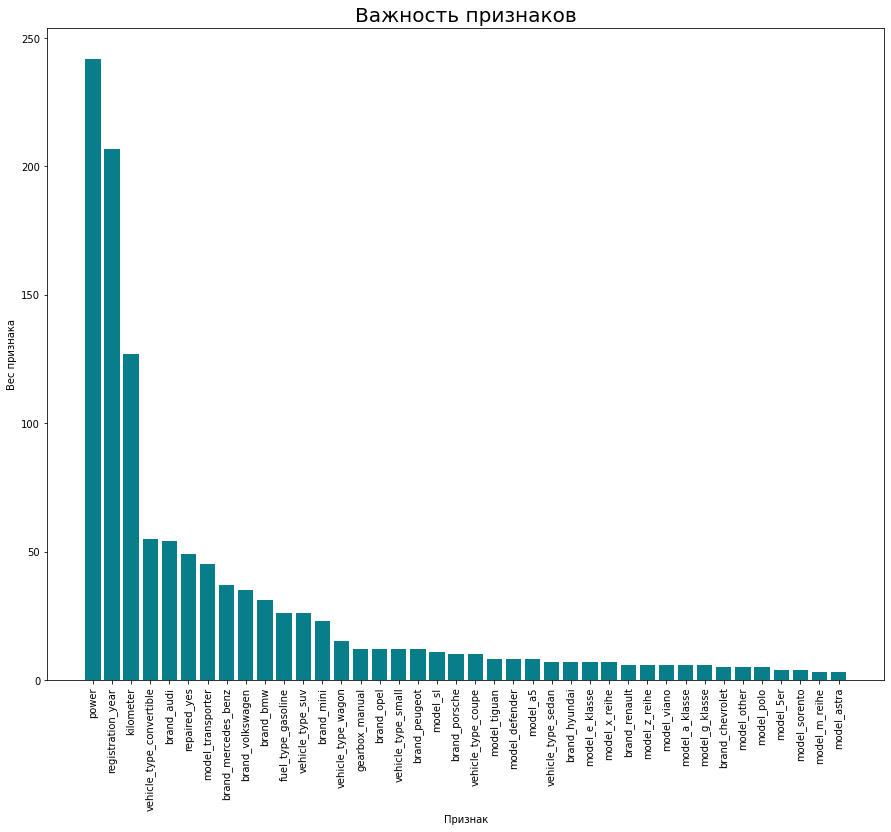

In [94]:
plt.bar(x=importances_lgb['Attribute'][:40],
        height=importances_lgb['Importance'][:40],
        color='#087E8B'
       )

# Добавление названия графику
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')

# Подпись осей X и Y
plt.xlabel("Признак")
plt.ylabel("Вес признака")

# Удаление технических комментариев и отображение графика
plt.show()

In [96]:
%%time

rmse_lgbm_tuned = -lgbm_cv_model.best_score_
print('RMSE LightGBM:', rmse_lgbm_tuned)

RMSE LightGBM: 1931.6045121510324
CPU times: user 430 µs, sys: 72 µs, total: 502 µs
Wall time: 295 µs


# Catboost

In [98]:
%%time

cbr_model = CatBoostRegressor(random_state=42, logging_level='Silent')

CPU times: user 91 µs, sys: 16 µs, total: 107 µs
Wall time: 111 µs


In [101]:
%%time
parameters_cb = {'iterations': [1000],
        'learning_rate': [0.03, 0.1],
        'depth': [6, 8],
        'l2_leaf_reg': [1, 3]
              }
model_CBR = CatBoostRegressor(random_state=42, 
                              loss_function='RMSE',
                              eval_metric = 'RMSE',
                              logging_level='Silent')
cb_model = GridSearchCV(estimator = model_CBR,
                        param_grid = parameters_cb,
                        cv = 4,
                        n_jobs=-1,
                        verbose=2,
                        scoring=rmse_score
                       )
cb_model.fit(features_train_scaled, target_train)
cb_model.best_params_

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.03; total time=  16.7s
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.03; total time=  16.0s
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.03; total time=  16.5s
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.03; total time=  16.6s
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1; total time=  16.9s
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1; total time=  16.1s
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1; total time=  16.5s
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1; total time=  17.0s
[CV] END depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.03; total time=  16.6s
[CV] END depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.03; total time=  15.7s
[CV] END depth=6, iterations=1000, l2_leaf_reg=3, lear

{'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [102]:
%%time
cb_tuned = CatBoostRegressor(**cb_model.best_params_, logging_level='Silent')

start_cat_fit= time()

cb_tuned.fit(features_train_scaled, target_train)

end_cat_fit = time()
model_time_cat_fit = (end_cat_fit-start_cat_fit)/60
print(f'Время обучения модели CatBoostRegressor: {round(model_time_cat_fit, 5)} min')

Время обучения модели CatBoostRegressor: 0.40669 min
CPU times: user 23.2 s, sys: 157 ms, total: 23.4 s
Wall time: 24.4 s


In [103]:
%%time

start_cat_pred = time()

y_pred_cat = cb_tuned.predict(features_train_scaled)

end_cat_pred = time()
model_time_cat_pred = (end_cat_pred-start_cat_pred)/60
print(f'Время предсказания модели CatBoostRegressor: {round(model_time_cat_pred, 5)} min')

Время предсказания модели CatBoostRegressor: 0.0048 min
CPU times: user 290 ms, sys: 408 µs, total: 291 ms
Wall time: 288 ms


In [105]:
%%time

cbr_rmse = - cb_model.best_score_
print("RMSE Catboost: %.2f" % cbr_rmse)

RMSE Catboost: 1661.86
CPU times: user 370 µs, sys: 23 µs, total: 393 µs
Wall time: 215 µs


In [106]:
importances_cat = pd.DataFrame(data={
    'Attribute': features_train_scaled.columns,
    'Importance': cb_tuned.feature_importances_
})
importances_cat = importances_cat.sort_values(by='Importance', ascending=False)

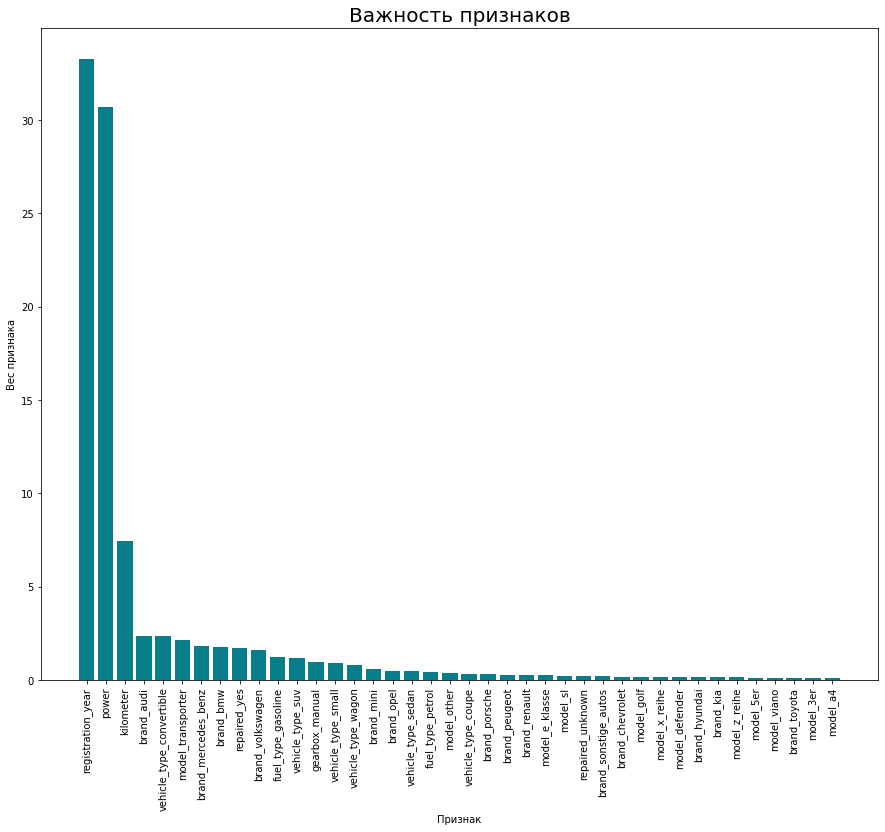

In [108]:
plt.bar(x=importances_cat['Attribute'][:40], 
        height=importances_cat['Importance'][:40],
        color='#087E8B')

# Добавление названия графику
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')

# Подпись осей X и Y
plt.xlabel("Признак")
plt.ylabel("Вес признака")

# Удаление технических комментариев и отображение графика
plt.show()

## Анализ моделей

In [109]:
print('LinearRegression:', end = '')
print()
print(f'RMSE:{rmse_lr_tuned}, скорость предсказания: {round(model_time_lr_pred, 5)} min, \
время обучения: {round(model_time_lr_fit, 2)} min')

LinearRegression:
RMSE:2323.624070688469, скорость предсказания: 0.00507 min, время обучения: 0.3 min


In [110]:
print('LightGBM:', end = '')
print()
print(f'RMSE:{rmse_lgbm_tuned}, скорость предсказания: {round(model_time_lgbm_tuned_pred, 5)} min, \
время обучения: {round(model_time_lgbm_tuned_fit, 5)} min')

LightGBM:
RMSE:1931.6045121510324, скорость предсказания: 0.0168 min, время обучения: 0.40184 min


In [111]:
print('Catboost:', end = '')
print()
print(f'RMSE:{cbr_rmse}, скорость предсказания: {round(model_time_cat_pred, 5)} min, \
время обучения: {round(model_time_cat_fit, 5)} min')

Catboost:
RMSE:1661.8582804630898, скорость предсказания: 0.0048 min, время обучения: 0.40669 min


Лучшая модель - Catboost

In [112]:
%%time
final_cbr_pred = cb_tuned.predict(features_test_scaled)

CPU times: user 93.2 ms, sys: 0 ns, total: 93.2 ms
Wall time: 98.9 ms


In [113]:
final_cbr_rmse = np.sqrt(mse(target_test, final_cbr_pred))
print("RMSE: %.2f" % final_cbr_rmse)

RMSE: 1682.63


In [114]:
X = features_train_scaled.values
y = target_train.values

X_test = features_test_scaled.values
y_test = target_test.values

# Создаем модель DummyRegressor
model_dr = DummyRegressor(strategy='mean')

# Обучаем модель
model_dr.fit(X, y)

# Прогнозируем значения 
y_pred = model_dr.predict(X_test)

# Оцениваем качество модели
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Dummy RMSE:", rmse)

Dummy RMSE: 4514.863945349966


<div class="alert-info">Наша модель Catboost лучше базлайн модели.</div>

# **Вывод по проекту**
<div class="alert-info">
Мы устранили пропуски в данных, лишние признаки, аномальные значения и выбросы.Мы обучили несколько моделей, лучшей из которых оказалась catboost, с показателями на тестовых данных RMSE: 1682.63; скорость предсказания: 0.0048 min, время обучения: 0.40669 min. LinearRegression оказалась худшей моделью. Цель проекта достигнута.
</div></div>